# PageRank analysis 
This notebook explores several extensions and analyses of the PageRank algorithm through a sequence of interconnected exercises. Starting from a baseline web graph, we progressively modify its structure—first by adding mutually linked pages, then by introducing a page that points to all others without receiving incoming links. These variations allow us to observe how structural changes influence ranking outcomes when using both the raw link matrix \( A \) and the Google matrix \( M \) with damping factor \( m = 0.15 \).

In addition to computing updated PageRank vectors, we examine the convergence behaviour of the power method by tracking the evolution of error norms over multiple iterations. This includes estimating key quantities such as the constant \( c \) and the magnitude of the second largest eigenvalue, which together help characterize the speed at which the PageRank computation stabilizes.

Throughout the notebook, the focus remains on practical computation: algebraic methods, iterative algorithms, and graphical analyses are used to illustrate how PageRank responds to changes in the underlying web structure.


## Exercise 11

In [25]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ipywidgets import interact, FloatSlider
import networkx as nx
from matplotlib.animation import FuncAnimation

A = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
], dtype=float)


def pagerank_power_method_classic(A, m, max_iter=1000, tol=1e-10):
    n = A.shape[0]
    S = np.ones((n, n)) / n
    M = (1 - m) * A + m * S
    v = np.ones(n)
    v /= np.linalg.norm(v, 2)
    
    lam_old = None
    lambdas = []
    errors = []
    history = [v.copy()]
    
    for _ in range(max_iter):
        w = M @ v
        lam = v @ w
        lambdas.append(lam)
        v = w / np.linalg.norm(w, 2)
        history.append(v.copy())
        
        if lam_old is None:
            errors.append(np.nan)
        else:
            error = abs(lam - lam_old)
            errors.append(error)
            if error < tol * max(abs(lam), 1e-12):
                break
        
        lam_old = lam
    
    v = v / v.sum()
    return v, np.array(lambdas), np.array(errors), np.array(history)



def plot_pagerank_classic(m):
    v,_,_,_ = pagerank_power_method_classic(A,m)

    plt.figure(figsize=(7, 4))
    plt.bar(range(1, n+1), v)
    plt.ylim(0, 0.5)
    plt.xlabel('Pagina')
    plt.ylabel('Rank')
    plt.title(f'Classic Power Method – PageRank (m = {m:.2f})')

    for i, val in enumerate(v):
        plt.text(i+1, val + 0.01, f"{val:.3f}", ha='center')

    plt.show()


interact(
    plot_pagerank_classic,
    m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m')
);

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

In [26]:
def plot_rayleigh_and_error(m):
    _,lambdas, errors,_ = pagerank_power_method_classic(A,m)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(lambdas, marker='o')
    ax[0].set_title("Rayleigh Quotient Evolution")
    ax[0].set_xlabel("Iteration")

    mask = np.isfinite(errors)
    ax[1].plot(np.where(mask)[0], errors[mask], marker='o')
    ax[1].set_yscale("log")
    ax[1].set_title("|λ(m+1) − λ(m)| (log scale)")
    ax[1].set_xlabel("Iteration")

    plt.tight_layout()
    plt.show()


interact(
    plot_rayleigh_and_error,
    m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m')
);


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

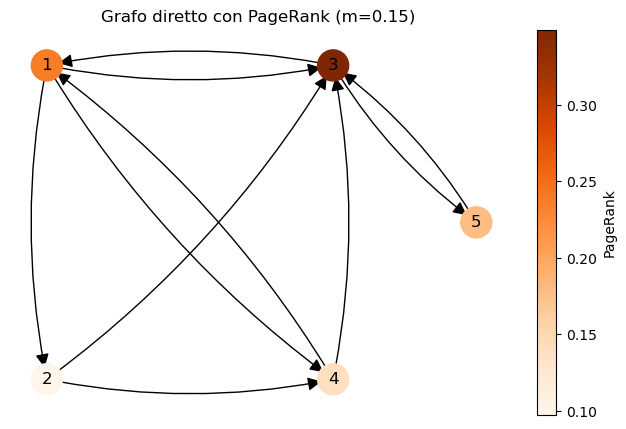

In [27]:
v,_,_,_ = pagerank_power_method_classic(A,0.15)

G = nx.DiGraph()
G.add_nodes_from(range(1,5))

for i in range(n):
    for j in range(n):
        if A[i,j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),     
    3: (1, 1),     
    2: (0, 0),     
    4: (1, 0),     
    5: (1.5, 0.5)  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  


fig, ax = plt.subplots(figsize=(8,5))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],
                           connectionstyle='arc3,rad=0.1',
                           arrowstyle='-|>', arrowsize=20,
                           ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'Grafo diretto con PageRank (m={0.15})')
ax.axis('off')
plt.show()

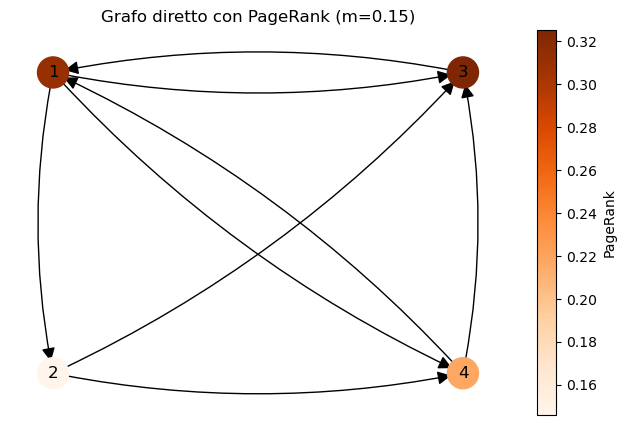

In [28]:
A4 = np.array([
    [0,   0,   1/2, 1/2],
    [1/3, 0,   0,   0],
    [1/3, 1/2, 0,   1/2],
    [1/3, 1/2, 0,   0]
])
n4=A4.shape[0]
v,_,_,_ = pagerank_power_method_classic(A4,0.15)

G = nx.DiGraph()
G.add_nodes_from(range(1,n4+1))

for i in range(n4):
    for j in range(n4):
        if A[i,j] > 0:
            G.add_edge(j+1, i+1)


pos = {
    1: (0, 1),     
    3: (1, 1),     
    2: (0, 0),    
    4: (1, 0),  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  

fig, ax = plt.subplots(figsize=(8,5))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],
                           connectionstyle='arc3,rad=0.1',
                           arrowstyle='-|>', arrowsize=20,
                           ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'Grafo diretto con PageRank (m={0.15})')
ax.axis('off')
plt.show()

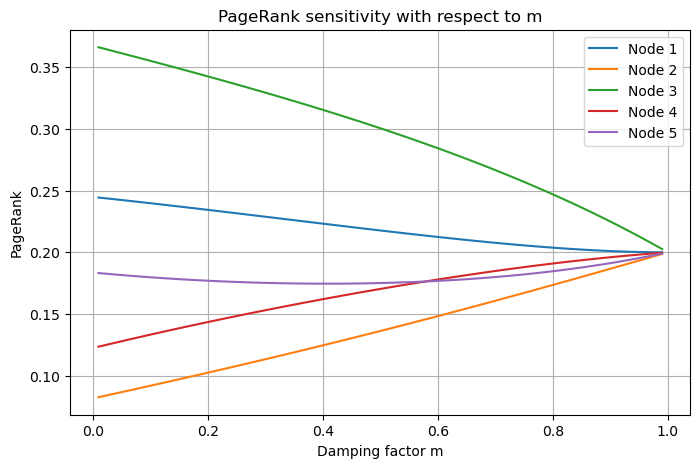

In [30]:
m_values = np.linspace(0.01, 0.99, 50)
pagerank_vs_m = []

for m_val in m_values:
    pr, _, _, _ = pagerank_power_method_classic(A, m=m_val)
    pagerank_vs_m.append(pr)

pagerank_vs_m = np.array(pagerank_vs_m)

plt.figure(figsize=(8, 5))
for i in range(n):
    plt.plot(m_values, pagerank_vs_m[:, i], label=f'Node {i+1}')

plt.xlabel('Damping factor m')
plt.ylabel('PageRank')
plt.title('PageRank sensitivity with respect to m')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [32]:
def plot_pagerank_comparison(m=0.15):
    nodes = ['1','2','3','4']
    v5,_,_,_ = pagerank_power_method_classic(A, m)
    v4,_,_,_ = pagerank_power_method_classic(A4, m)
    
    x = np.arange(len(nodes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x - width/2, v5[:4], width, label='5-page Web')
    ax.bar(x + width/2, v4, width, label='Original web')

    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_ylabel('PageRank')
    ax.set_title(f'Confronto PageRank: con 5 pagine vs senza pagina 5 (m={m:.2f})')

    ax.legend(loc='upper right')

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


interact(plot_pagerank_comparison, m=FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, min=0.01, step=0.01), Output()), _dom_…

In [37]:
def plot_pagerank_difference_relative(m=0.15):
    nodes = ['1','2','3','4']    
    v5,_,_,_ = pagerank_power_method_classic(A, m)
    v4,_,_,_= pagerank_power_method_classic(A4, m)
    v5_trim = v5[:4]
    
    diff_rel = ((v5_trim - v4) / v4) * 100
    
    x = np.arange(len(nodes))
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x, diff_rel, width=0.3, color='green', alpha=0.8)  

    ax.set_xticks(x)
    ax.set_xticklabels(nodes, fontsize=12)
    ax.set_title(f'Page 5 impact on PageRank', fontsize=13)
    ax.set_xlabel('Page')
    ax.set_ylabel('Relative Difference (%)')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_difference_relative, m=FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='m'));



interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, min=0.01, step=0.01), Output()), _dom_…